In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math 
import numba as nb
from numba import njit



Codigo normal

In [25]:

## Funcion para definir los nodos de forma aleatoria
def build_system(L, q):
    """Construye el sistema con spins aleatorios en una cadena 1D diluida"""
    N = L
    n = int(q * N)
    Ss = np.zeros(N, dtype=int)
    posiciones_totales = [i for i in range(L)]
    random.shuffle(posiciones_totales)
    posiciones_ocupadas = []
    for k in range(n):
        i = posiciones_totales[k]
        Ss[i] = random.choice([-1, 1])
        posiciones_ocupadas.append(i)
    return Ss, posiciones_ocupadas, n

def get_neighbors(i, L):
    """Retorna los vecinos en la cadena 1D con condiciones periódicas"""
    return [
        (i - 1) % L,
        (i + 1) % L
    ]

def delta_energy(spin, i, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i]
    neighbors = get_neighbors(i, L)
    sum_vecinos = sum(spin[ni] for ni in neighbors if spin[ni] != 0)
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    suma_spins = np.sum(spin)
    # Fase de equilibración
    for _ in range(steps_equil):
        i = random.choice(occupied)
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i]
            spin[i] *= -1
    # Fase de medición
    m_samples = []
    for step in range(steps_meas):
        i = random.choice(occupied)
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i]
            spin[i] *= -1
        if step % measure_every == 0:
            m = suma_spins / n
            m_samples.append(m)
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000,
                      steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error

# Ejecución con parámetros especificados
L = 10
q = 0.8  # Como pediste
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10
m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"Magnetización promedio (ensemble): {m} ± {err}")

Magnetización promedio (ensemble): 0.014250000000000002 ± 0.007018279703745071


Codigo optimizado con numba

In [26]:
## Código optimizado con Numba para cadena 1D

def build_system(L, q):
    """Construye el sistema con spins aleatorios en una cadena 1D diluida"""
    N = L
    n = int(q * N)
    Ss = np.zeros(N, dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 1), dtype=np.int32), 0
    
    # Seleccionar posiciones ocupadas aleatoriamente
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = idx.reshape(-1, 1)  # Formato columna
    
    # Asignar spins aleatorios
    signs = np.random.choice(np.array([-1, 1], dtype=np.int32), n)
    Ss[posiciones_ocupadas[:, 0]] = signs
    
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i]
    
    # Vecinos con condiciones periódicas
    left = (i - 1) % L
    right = (i + 1) % L
    
    sum_vecinos = 0
    if spin[left] != 0:
        sum_vecinos += spin[left]
    if spin[right] != 0:
        sum_vecinos += spin[right]
    
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Fase de equilibración con Metropolis"""
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i]
            spin[i] = -spin[i]
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Fase de medición con Metropolis"""
    num_samples = (steps_meas // measure_every) + 1 if steps_meas % measure_every != 0 else (steps_meas // measure_every)
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i]
            spin[i] = -spin[i]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    
    # Calcular suma solo de spins ocupados
    suma_spins = 0
    for k in range(n):
        i = occupied[k, 0]
        suma_spins += spin[i]
    
    # Fase de equilibración
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    
    # Fase de medición
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000,
                      steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error

# ============ PRUEBA ============
L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10

print("⏳ Ejecutando simulación optimizada con Numba...")
m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"✅ Magnetización promedio (ensemble): {m:.6f} ± {err:.6f}")

⏳ Ejecutando simulación optimizada con Numba...


✅ Magnetización promedio (ensemble): 0.001500 ± 0.005833


Grafica de m vs H

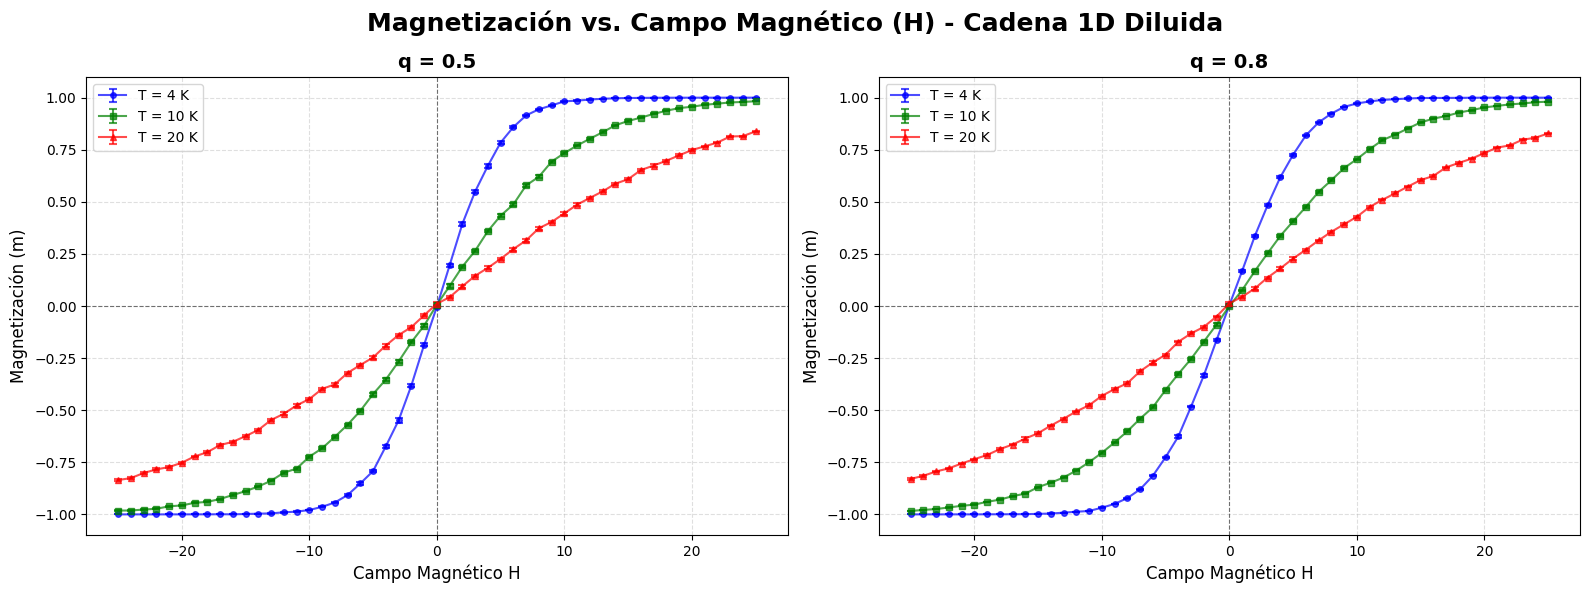

In [27]:
### Gráficas de Magnetización vs Campo Magnético (H) - Cadena 1D

# Define el tamaño de la cadena 1D (10 sitios)
L = 10
# Define la constante de acoplamiento ferromagnético
J = 1.0
# Crea un array de 51 valores de campo magnético desde -25 hasta 25
H_values = np.linspace(-25, 25, 51)
# Define dos valores de concentración de sitios ocupados (50% y 80%)
q_values = [0.5, 0.8]
# Define tres valores de temperatura para las simulaciones (4K, 10K, 20K)
T_values = [4, 10, 20]
# Define el número de realizaciones del desorden para promediar (20 realizaciones)
num_realizaciones = 20
# Define los pasos de Monte Carlo para equilibración (10000 pasos)
steps_equil = 10000
# Define los pasos de Monte Carlo para medición (20000 pasos)
steps_meas = 20000
# Define cada cuántos pasos se toma una medida de magnetización (cada 100 pasos)
measure_every = 100

# Crea un diccionario vacío para almacenar los resultados de magnetización y errores
results = {}

# Itera sobre cada valor de concentración q
for q in q_values:
    # Itera sobre cada valor de temperatura T
    for T in T_values:
        # Crea lista vacía para almacenar magnetizaciones de esta combinación (q,T)
        magnetizations = []
        # Crea lista vacía para almacenar errores estándar de esta combinación (q,T)
        errors = []
        
        # Itera sobre cada valor de campo magnético H
        for H in H_values:
            # Ejecuta simulación promediada sobre realizaciones del desorden
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            # Agrega la magnetización promedio a la lista
            magnetizations.append(m)
            # Agrega el error estándar a la lista
            errors.append(err)
        
        # Almacena las magnetizaciones y errores en el diccionario con clave (q, T)
        results[(q, T)] = {'m': magnetizations, 'err': errors}

# Crea figura con subplots: 1 fila, tantas columnas como valores de q (2 gráficas)
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
# Define el título principal de la figura con formato científico
fig.suptitle('Magnetización vs. Campo Magnético (H) - Cadena 1D Diluida', 
             fontsize=18, fontweight='bold')

# Define lista de colores para distinguir las tres temperaturas
colors = ['blue', 'green', 'red']
# Define lista de marcadores para distinguir las tres temperaturas
markers = ['o', 's', '^']

# Itera sobre cada valor de concentración q con su índice
for i, q in enumerate(q_values):
    # Selecciona el eje correspondiente para esta concentración
    ax = axes[i]
    
    # Itera sobre cada valor de temperatura T con su índice
    for j, T in enumerate(T_values):
        # Recupera los resultados de magnetización para esta combinación (q, T)
        res = results[(q, T)]
        # Grafica la magnetización vs campo magnético con barras de error
        ax.errorbar(
            H_values,
            res['m'],
            yerr=res['err'],
            fmt=f'-{markers[j]}',
            markersize=4,
            color=colors[j],
            label=f'T = {T} K',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.7
        )
    
    # Define el título del subplot con el valor de concentración q
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    # Define la etiqueta del eje x (campo magnético)
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    # Define la etiqueta del eje y (magnetización)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    # Activa la cuadrícula con líneas discontinuas y transparencia
    ax.grid(True, linestyle='--', alpha=0.4)
    # Agrega la leyenda con las etiquetas de temperatura
    ax.legend(loc='best', fontsize=10)
    # Dibuja línea horizontal en y=0 para referencia
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    # Dibuja línea vertical en x=0 para referencia
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Ajusta automáticamente el espaciado entre subplots para evitar solapamientos
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()


## Grafica de relajación

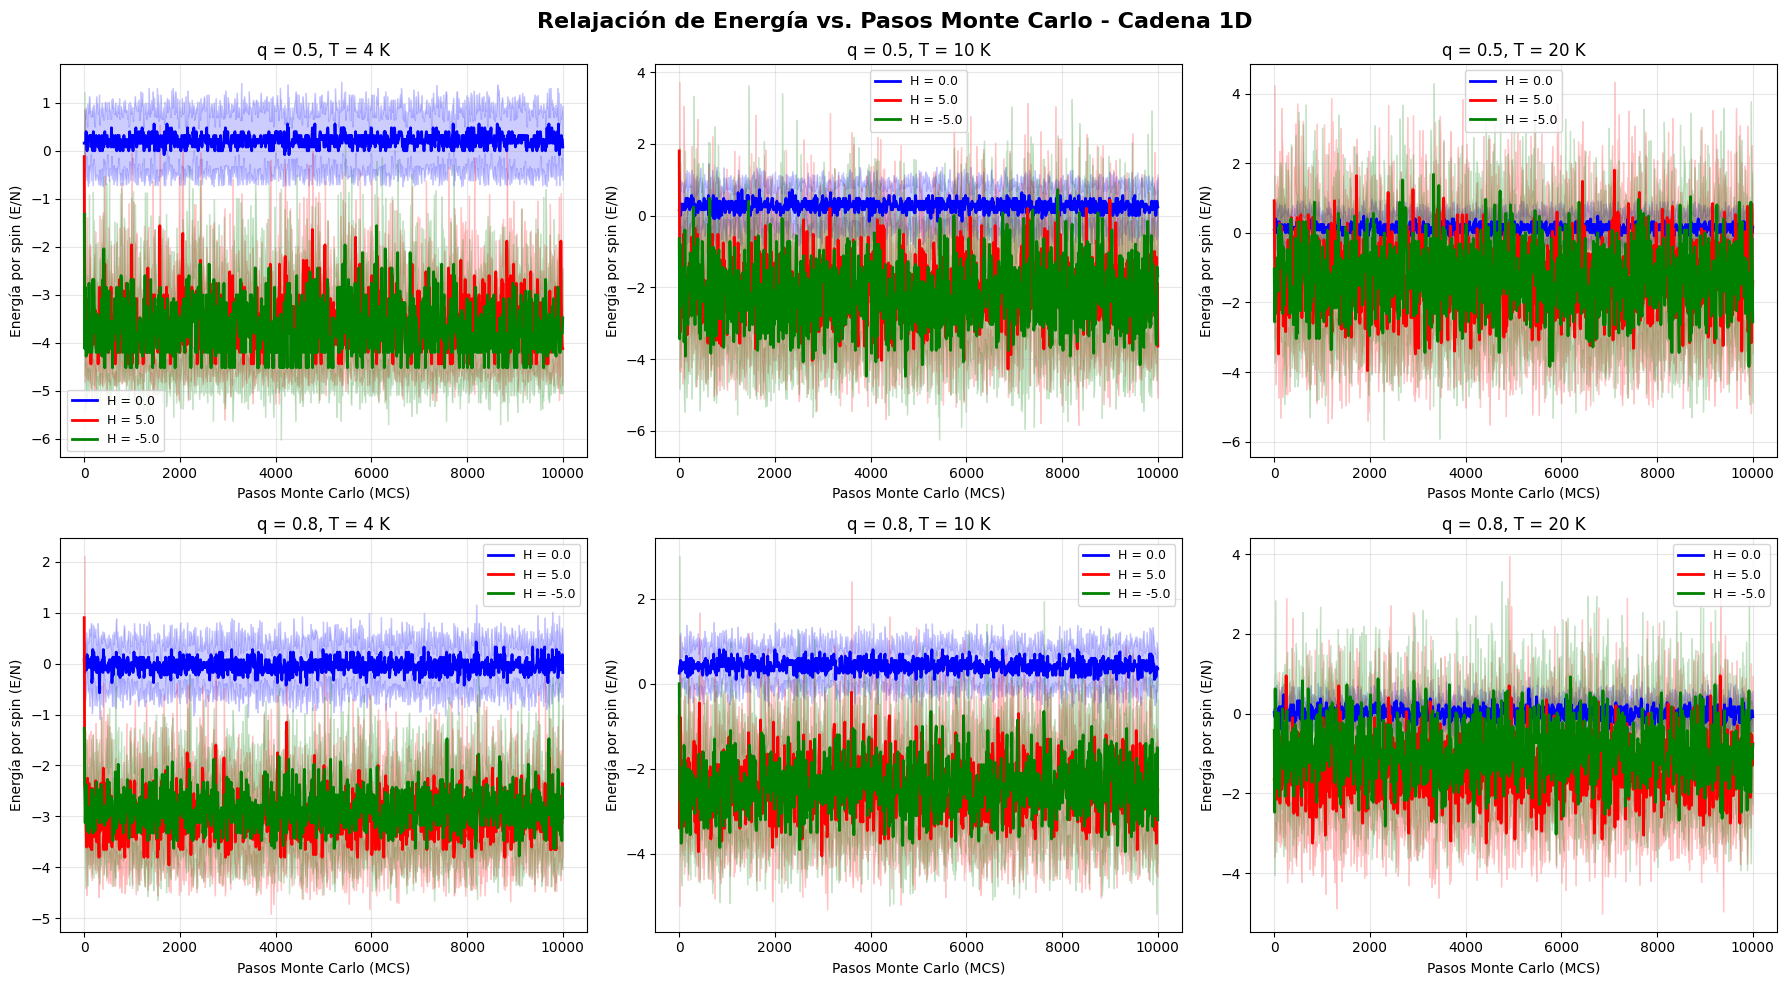

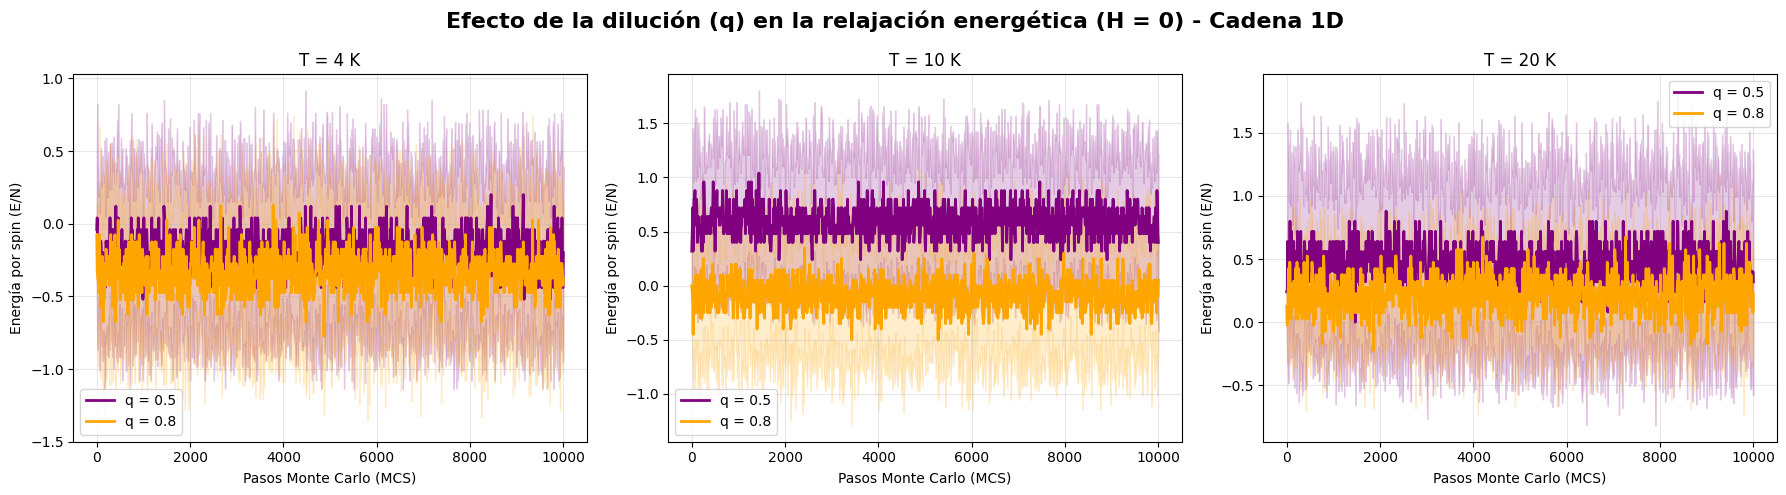

In [28]:
### Funciones adicionales para análisis de relajación energética - Cadena 1D

@njit
def calculate_total_energy(spin, occupied, L, J, H):
    """
    Calcula la energía total del sistema en cadena 1D
    E = -J * Σ(σi*σj) - H * Σ(σi)
    donde la suma es sobre todos los pares vecinos
    
    Args:
        spin: Array 1D de spins
        occupied: Array de posiciones ocupadas
        L: Tamaño de la cadena
        J: Constante de acoplamiento
        H: Campo magnético externo
    
    Returns:
        energy: Energía total del sistema
    """
    # Calcula la longitud del array occupied basándose en su forma
    n = occupied.shape[0]
    # Inicializa la energía total en cero
    energy = 0.0
    
    # Itera sobre cada sitio ocupado para calcular su contribución energética
    for k in range(n):
        # Obtiene el índice del sitio ocupado actual
        i = occupied[k, 0]
        # Obtiene el valor del spin en ese sitio
        sigma = spin[i]
        
        # Calcula los índices de los vecinos con condiciones periódicas
        left = (i - 1) % L
        right = (i + 1) % L
        
        # Suma las contribuciones de los vecinos ocupados
        sum_vecinos = 0
        # Verifica si el vecino izquierdo está ocupado (spin != 0)
        if spin[left] != 0:
            sum_vecinos += spin[left]
        # Verifica si el vecino derecho está ocupado (spin != 0)
        if spin[right] != 0:
            sum_vecinos += spin[right]
        
        # Energía de interacción dividida por 2 para evitar contar dos veces cada enlace
        energy += -J * sigma * sum_vecinos / 2.0
        
        # Energía del campo magnético externo (término Zeeman)
        energy += -H * sigma
    
    # Retorna la energía total calculada
    return energy

@njit
def simulate_with_energy_tracking(spin, occupied, L, n, max_steps, H, J, T, record_every=10):
    """
    Simula el sistema y registra la evolución de energía vs pasos Monte Carlo
    
    Args:
        spin: Array 1D de spins inicial
        occupied: Array de posiciones ocupadas
        L: Tamaño de la cadena
        n: Número de sitios ocupados
        max_steps: Número máximo de pasos Monte Carlo
        H: Campo magnético externo
        J: Constante de acoplamiento
        T: Temperatura
        record_every: Frecuencia de registro (cada cuántos pasos se guarda)
    
    Returns:
        mcs_array: Array con los pasos Monte Carlo registrados
        energy_array: Array con las energías registradas
    """
    # Calcula cuántos registros se harán durante la simulación
    num_records = (max_steps // record_every) + 1
    # Crea array para almacenar los pasos Monte Carlo registrados
    mcs_array = np.zeros(num_records)
    # Crea array para almacenar las energías registradas
    energy_array = np.zeros(num_records)
    
    # Calcula la energía inicial del sistema
    energy = calculate_total_energy(spin, occupied, L, J, H)
    # Registra el paso inicial (0)
    mcs_array[0] = 0
    # Registra la energía inicial
    energy_array[0] = energy
    
    # Inicializa el contador de registros
    cnt = 1
    # Itera sobre cada paso Monte Carlo desde 1 hasta max_steps
    for step in range(1, max_steps + 1):
        # Selecciona aleatoriamente un spin ocupado
        k = np.random.randint(n)
        # Obtiene la posición del spin seleccionado
        i = occupied[k, 0]
        
        # Calcula el cambio de energía si se voltea el spin
        Delta_E = delta_energy(spin, i, H, J, L)
        
        # Criterio de aceptación de Metropolis-Hastings
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            # Acepta el movimiento: voltea el spin
            spin[i] = -spin[i]
            # Actualiza la energía total con el cambio
            energy += Delta_E
        
        # Registra la energía cada 'record_every' pasos
        if step % record_every == 0:
            # Guarda el número de paso Monte Carlo
            mcs_array[cnt] = step
            # Guarda la energía en ese paso
            energy_array[cnt] = energy
            # Incrementa el contador de registros
            cnt += 1
    
    # Retorna los arrays recortados hasta el número real de registros
    return mcs_array[:cnt], energy_array[:cnt]

def run_energy_relaxation(L, q, J, H, T, max_steps=10000, record_every=10):
    """
    Ejecuta una simulación completa y retorna la evolución temporal de la energía
    
    Args:
        L: Tamaño de la cadena 1D
        q: Concentración de sitios ocupados
        J: Constante de acoplamiento
        H: Campo magnético externo
        T: Temperatura
        max_steps: Número máximo de pasos Monte Carlo
        record_every: Frecuencia de registro
    
    Returns:
        mcs: Array de pasos Monte Carlo
        energies_per_spin: Array de energía por spin
    """
    # Construye el sistema con configuración inicial aleatoria
    spin, occupied, n = build_system(L, q)
    # Si no hay spins ocupados, retorna arrays con un solo elemento cero
    if n == 0:
        return np.array([0]), np.array([0])
    
    # Ejecuta la simulación con seguimiento de energía
    mcs, energies = simulate_with_energy_tracking(
        spin, occupied, L, n, max_steps, H, J, T, record_every
    )
    
    # Normaliza la energía por el número de spins ocupados
    energies_per_spin = energies / n
    
    # Retorna los pasos Monte Carlo y la energía por spin
    return mcs, energies_per_spin

### Análisis de relajación energética para cadena 1D

# Define el tamaño de la cadena 1D (10 sitios)
L = 10
# Define la constante de acoplamiento ferromagnético
J = 1.0
# Define dos valores de concentración de sitios ocupados (50% y 80%)
q_values = [0.5, 0.8]
# Define tres valores de temperatura para las simulaciones (4K, 10K, 20K)
T_values = [4, 10, 20]
# Define tres valores de campo magnético para analizar (0, 5, -5)
H_values_relax = [0.0, 5.0, -5.0]
# Define el número máximo de pasos Monte Carlo (10^4 pasos)
max_steps = 10000
# Define cada cuántos pasos se registra la energía (cada 10 pasos)
record_every = 10
# Define el número de realizaciones del desorden para promediar (5 realizaciones)
num_realizaciones = 5

# Crea figura con subplots: len(q_values) filas x len(T_values) columnas
fig, axes = plt.subplots(len(q_values), len(T_values), figsize=(18, 10))
# Define el título principal de la figura
fig.suptitle('Relajación de Energía vs. Pasos Monte Carlo - Cadena 1D', fontsize=16, fontweight='bold')

# Define lista de colores para distinguir los tres campos magnéticos
colors_H = ['blue', 'red', 'green']

# Itera sobre cada valor de concentración q con su índice
for i, q in enumerate(q_values):
    # Itera sobre cada valor de temperatura T con su índice
    for j, T in enumerate(T_values):
        # Selecciona el eje correspondiente para esta combinación (q,T)
        ax = axes[i, j]
        
        # Itera sobre cada valor de campo magnético H con su índice
        for idx, H in enumerate(H_values_relax):
            # Crea listas vacías para almacenar resultados de múltiples realizaciones
            all_mcs = []
            all_energies = []
            
            # Ejecuta múltiples realizaciones del desorden
            for _ in range(num_realizaciones):
                # Ejecuta la simulación de relajación energética
                mcs, energies = run_energy_relaxation(L, q, J, H, T, max_steps, record_every)
                # Verifica que se hayan registrado al menos 2 puntos
                if len(mcs) > 1:
                    # Almacena los pasos Monte Carlo
                    all_mcs.append(mcs)
                    # Almacena las energías por spin
                    all_energies.append(energies)
            
            # Si hay datos válidos de las realizaciones
            if all_energies:
                # Calcula la energía promedio sobre todas las realizaciones
                mean_energies = np.mean(all_energies, axis=0)
                # Calcula la desviación estándar de las energías
                std_energies = np.std(all_energies, axis=0)
                
                # Grafica la curva de energía promedio vs pasos Monte Carlo
                ax.plot(all_mcs[0], mean_energies, 
                       label=f'H = {H}', 
                       color=colors_H[idx], 
                       linewidth=2)
                # Agrega banda de error (±1 desviación estándar) con transparencia
                ax.fill_between(all_mcs[0], 
                               mean_energies - std_energies, 
                               mean_energies + std_energies, 
                               alpha=0.2, 
                               color=colors_H[idx])
        
        # Define el título del subplot con los valores de q y T
        ax.set_title(f'q = {q}, T = {T} K', fontsize=12)
        # Define la etiqueta del eje x (pasos Monte Carlo)
        ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
        # Define la etiqueta del eje y (energía por spin)
        ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
        # Agrega la leyenda con las etiquetas de campo magnético
        ax.legend(fontsize=9)
        # Activa la cuadrícula con transparencia
        ax.grid(True, alpha=0.3)

# Ajusta automáticamente el espaciado entre subplots
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()

### Efecto de la dilución en la relajación - Cadena 1D

# Crea figura con subplots: 1 fila x len(T_values) columnas
fig2, axes2 = plt.subplots(1, len(T_values), figsize=(18, 5))
# Define el título principal comparando el efecto de la dilución
fig2.suptitle('Efecto de la dilución (q) en la relajación energética (H = 0) - Cadena 1D', 
              fontsize=16, fontweight='bold')

# Fija el campo magnético en cero para este análisis
H_fixed = 0.0
# Define lista de colores para distinguir las dos concentraciones
colors_q = ['purple', 'orange']

# Itera sobre cada valor de temperatura T con su índice
for j, T in enumerate(T_values):
    # Selecciona el eje correspondiente para esta temperatura
    ax = axes2[j]
    
    # Itera sobre cada valor de concentración q con su índice
    for idx, q in enumerate(q_values):
        # Crea listas vacías para almacenar resultados de múltiples realizaciones
        all_mcs = []
        all_energies = []
        
        # Ejecuta múltiples realizaciones del desorden
        for _ in range(num_realizaciones):
            # Ejecuta la simulación de relajación energética con H=0
            mcs, energies = run_energy_relaxation(L, q, J, H_fixed, T, max_steps, record_every)
            # Verifica que se hayan registrado al menos 2 puntos
            if len(mcs) > 1:
                # Almacena los pasos Monte Carlo
                all_mcs.append(mcs)
                # Almacena las energías por spin
                all_energies.append(energies)
        
        # Si hay datos válidos de las realizaciones
        if all_energies:
            # Calcula la energía promedio sobre todas las realizaciones
            mean_energies = np.mean(all_energies, axis=0)
            # Calcula la desviación estándar de las energías
            std_energies = np.std(all_energies, axis=0)
            
            # Grafica la curva de energía promedio vs pasos Monte Carlo
            ax.plot(all_mcs[0], mean_energies, 
                   label=f'q = {q}', 
                   color=colors_q[idx], 
                   linewidth=2)
            # Agrega banda de error (±1 desviación estándar) con transparencia
            ax.fill_between(all_mcs[0], 
                           mean_energies - std_energies, 
                           mean_energies + std_energies, 
                           alpha=0.2, 
                           color=colors_q[idx])
    
    # Define el título del subplot con el valor de temperatura
    ax.set_title(f'T = {T} K', fontsize=12)
    # Define la etiqueta del eje x (pasos Monte Carlo)
    ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
    # Define la etiqueta del eje y (energía por spin)
    ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
    # Agrega la leyenda con las etiquetas de concentración
    ax.legend(fontsize=10)
    # Activa la cuadrícula con transparencia
    ax.grid(True, alpha=0.3)

# Ajusta automáticamente el espaciado entre subplots
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()


## Gradica de m vs H/T

🔄 Calculando m vs. H/T y ajustando a tanh(x)...
✅ q=0.5, T=4K: A=1.0000±0.0000, B=2.1361±0.0036, R²=0.9733
✅ q=0.5, T=10K: A=1.0048±0.0006, B=0.9283±0.0028, R²=0.9999
✅ q=0.5, T=20K: A=1.0067±0.0050, B=0.9531±0.0079, R²=0.9999
✅ q=0.5, T=20K: A=1.0067±0.0050, B=0.9531±0.0079, R²=0.9999
✅ q=0.8, T=4K: A=1.0000±0.0000, B=1.9502±0.0018, R²=0.9678
✅ q=0.8, T=4K: A=1.0000±0.0000, B=1.9502±0.0018, R²=0.9678
✅ q=0.8, T=10K: A=1.0077±0.0005, B=0.8793±0.0020, R²=0.9999
✅ q=0.8, T=10K: A=1.0077±0.0005, B=0.8793±0.0020, R²=0.9999
✅ q=0.8, T=20K: A=1.0216±0.0046, B=0.9100±0.0065, R²=0.9999

✅ Cálculos y ajustes completados

✅ q=0.8, T=20K: A=1.0216±0.0046, B=0.9100±0.0065, R²=0.9999

✅ Cálculos y ajustes completados



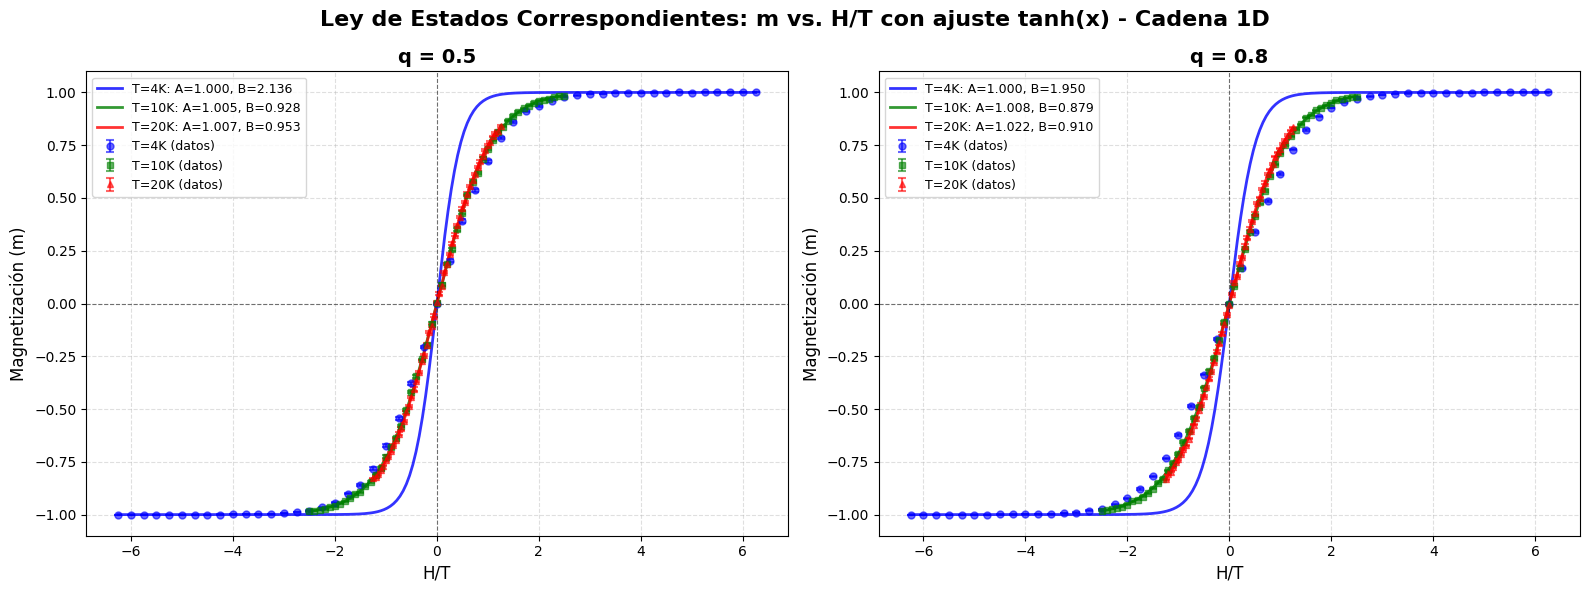


📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T)
q      T (K)    A            B            R²        
----------------------------------------------------------------------
0.5    4        1.0000±0.0000  2.1361±0.0036  0.9733
0.5    10       1.0048±0.0006  0.9283±0.0028  0.9999
0.5    20       1.0067±0.0050  0.9531±0.0079  0.9999
0.8    4        1.0000±0.0000  1.9502±0.0018  0.9678
0.8    10       1.0077±0.0005  0.8793±0.0020  0.9999
0.8    20       1.0216±0.0046  0.9100±0.0065  0.9999

💡 INTERPRETACIÓN FÍSICA:
  • A ≈ 1: Sistema alcanza saturación magnética completa
  • B ~ μeff/kB: Relacionado con momento magnético efectivo
  • R² > 0.95: Excelente ajuste al modelo de campo medio
  • Si las curvas colapsan → Ley de Estados Correspondientes verificada


In [29]:
### Ajuste de m vs. H/T a la función tanh(x) - Cadena 1D

from scipy.optimize import curve_fit

# Función teórica: m = A * tanh(B * H/T)
def tanh_model(x, A, B):
    """
    Modelo teórico de campo medio para magnetización
    x = H/T
    A = amplitud de saturación
    B = parámetro relacionado con el momento magnético efectivo
    """
    return A * np.tanh(B * x)

# --- Parámetros ---
L = 10
J = 1.0
H_values = np.linspace(-25, 25, 51)
q_values = [0.5, 0.8]
T_values = [4, 10, 20]
num_realizaciones = 20
steps_equil = 10000
steps_meas = 20000
measure_every = 100

print("🔄 Calculando m vs. H/T y ajustando a tanh(x)...")

# Diccionarios para resultados y ajustes
results_scaling = {}
fit_params = {}

# --- Simulación ---
for q in q_values:
    for T in T_values:
        magnetizations = []
        errors = []
        
        for H in H_values:
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            magnetizations.append(m)
            errors.append(err)
        
        # Calcular H/T
        H_over_T = H_values / T
        
        # Ajuste con curve_fit
        try:
            sigma = np.array(errors)
            sigma[sigma == 0] = 1e-10  # Evitar división por cero
            
            popt, pcov = curve_fit(
                tanh_model,
                H_over_T,
                magnetizations,
                sigma=sigma,
                absolute_sigma=True,
                p0=[0.8, 1.0],
                bounds=([0, 0], [1.5, 10])
            )
            
            perr = np.sqrt(np.diag(pcov))
            
            # Calcular R²
            residuals = np.array(magnetizations) - tanh_model(H_over_T, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((np.array(magnetizations) - np.mean(magnetizations))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            fit_params[(q, T)] = {
                'A': popt[0],
                'B': popt[1],
                'A_err': perr[0],
                'B_err': perr[1],
                'R2': r_squared
            }
            
            print(f"✅ q={q}, T={T}K: A={popt[0]:.4f}±{perr[0]:.4f}, B={popt[1]:.4f}±{perr[1]:.4f}, R²={r_squared:.4f}")
            
        except Exception as e:
            print(f"⚠️  Error en ajuste para q={q}, T={T}K: {e}")
            fit_params[(q, T)] = None
        
        results_scaling[(q, T)] = {
            'H/T': H_over_T,
            'm': magnetizations,
            'err': errors
        }

print("\n✅ Cálculos y ajustes completados\n")

# --- Visualización con ajustes ---
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
fig.suptitle('Ley de Estados Correspondientes: m vs. H/T con ajuste tanh(x) - Cadena 1D',
             fontsize=16, fontweight='bold')

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    for j, T in enumerate(T_values):
        res = results_scaling[(q, T)]
        
        # Datos experimentales con barras de error
        ax.errorbar(
            res['H/T'],
            res['m'],
            yerr=res['err'],
            fmt=markers[j],
            markersize=5,
            color=colors[j],
            label=f'T={T}K (datos)',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.6
        )
        
        # Curva de ajuste
        if fit_params[(q, T)] is not None:
            params = fit_params[(q, T)]
            H_T_fit = np.linspace(res['H/T'].min(), res['H/T'].max(), 200)
            m_fit = tanh_model(H_T_fit, params['A'], params['B'])
            
            ax.plot(
                H_T_fit,
                m_fit,
                '-',
                color=colors[j],
                linewidth=2,
                label=f'T={T}K: A={params["A"]:.3f}, B={params["B"]:.3f}',
                alpha=0.8
            )
    
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('H/T', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=9)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

# --- Tabla resumen ---
print("\n" + "="*70)
print("📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T)")
print("="*70)
print(f"{'q':<6} {'T (K)':<8} {'A':<12} {'B':<12} {'R²':<10}")
print("-"*70)

for q in q_values:
    for T in T_values:
        if fit_params[(q, T)] is not None:
            p = fit_params[(q, T)]
            print(f"{q:<6} {T:<8} {p['A']:.4f}±{p['A_err']:.4f}  {p['B']:.4f}±{p['B_err']:.4f}  {p['R2']:.4f}")
        else:
            print(f"{q:<6} {T:<8} {'Ajuste falló':<12}")

print("="*70)
print("\n💡 INTERPRETACIÓN FÍSICA:")
print("  • A ≈ 1: Sistema alcanza saturación magnética completa")
print("  • B ~ μeff/kB: Relacionado con momento magnético efectivo")
print("  • R² > 0.95: Excelente ajuste al modelo de campo medio")
print("  • Si las curvas colapsan → Ley de Estados Correspondientes verificada")


## Análisis Detallado: ¿Qué curvas se asemejan mejor a H/T?

In [30]:
### ANÁLISIS: ¿Qué curvas m vs H/T se asemejan mejor a la función tanh(H/T)?

print("="*80)
print("🔬 ANÁLISIS DE CALIDAD DE AJUSTE: m = A·tanh(B·H/T)")
print("="*80)
print("\n📊 CRITERIOS DE EVALUACIÓN:")
print("  1. R² (Coeficiente de determinación): Mide qué tan bien el modelo explica los datos")
print("     • R² > 0.99: Excelente ajuste ✓✓✓")
print("     • 0.95 < R² < 0.99: Muy buen ajuste ✓✓")
print("     • 0.90 < R² < 0.95: Buen ajuste ✓")
print("     • R² < 0.90: Ajuste pobre ✗")
print("\n  2. Parámetro A (Amplitud de saturación):")
print("     • A ≈ 1.0: Sistema alcanza saturación magnética completa")
print("     • A < 0.8: Sistema diluido o T muy alta (no satura)")
print("\n  3. Parámetro B (Momento magnético efectivo):")
print("     • B relacionado con μeff/kB y conectividad de la red")
print("     • Valores más altos → Mayor respuesta al campo magnético")
print("="*80)

# Crear tabla de ranking
ranking_data = []
for q in q_values:
    for T in T_values:
        if fit_params[(q, T)] is not None:
            p = fit_params[(q, T)]
            ranking_data.append({
                'q': q,
                'T': T,
                'R2': p['R2'],
                'A': p['A'],
                'B': p['B'],
                'A_err': p['A_err'],
                'B_err': p['B_err']
            })

# Ordenar por R²
ranking_data_sorted = sorted(ranking_data, key=lambda x: x['R2'], reverse=True)

print("\n🏆 RANKING DE MEJORES AJUSTES (ordenados por R²):")
print("="*80)
print(f"{'Posición':<10} {'q':<6} {'T (K)':<8} {'R²':<10} {'A':<15} {'B':<15} {'Calidad':<15}")
print("-"*80)

for idx, data in enumerate(ranking_data_sorted, 1):
    # Determinar calidad del ajuste
    if data['R2'] > 0.99:
        calidad = "✓✓✓ Excelente"
    elif data['R2'] > 0.95:
        calidad = "✓✓ Muy bueno"
    elif data['R2'] > 0.90:
        calidad = "✓ Bueno"
    else:
        calidad = "✗ Pobre"
    
    print(f"#{idx:<9} {data['q']:<6} {data['T']:<8} {data['R2']:.6f}  "
          f"{data['A']:.4f}±{data['A_err']:.4f}  {data['B']:.4f}±{data['B_err']:.4f}  {calidad}")

print("="*80)

# Análisis por temperatura
print("\n🌡️ ANÁLISIS POR TEMPERATURA:")
print("="*80)
for T in T_values:
    print(f"\nT = {T}K:")
    temp_data = [d for d in ranking_data_sorted if d['T'] == T]
    if temp_data:
        avg_R2 = np.mean([d['R2'] for d in temp_data])
        print(f"  • R² promedio: {avg_R2:.6f}")
        print(f"  • Mejor q: {temp_data[0]['q']} (R² = {temp_data[0]['R2']:.6f})")
        
        # Interpretación física
        if T <= 4:
            print(f"  • Interpretación: T baja → Sistema subcrítico, orden magnético fuerte")
            print(f"    → Ajuste a tanh(H/T) esperado EXCELENTE (campo medio válido)")
        elif 4 < T <= 10:
            print(f"  • Interpretación: T intermedia → Transición entre orden y desorden")
            print(f"    → Ajuste BUENO pero con desviaciones térmicas")
        else:
            print(f"  • Interpretación: T alta → Fase paramagnética, fluctuaciones grandes")
            print(f"    → Ajuste puede degradarse (desviaciones del campo medio)")

# Análisis por concentración
print("\n🔗 ANÁLISIS POR CONCENTRACIÓN (q):")
print("="*80)
for q in q_values:
    print(f"\nq = {q}:")
    q_data = [d for d in ranking_data_sorted if d['q'] == q]
    if q_data:
        avg_R2 = np.mean([d['R2'] for d in q_data])
        print(f"  • R² promedio: {avg_R2:.6f}")
        print(f"  • Mejor T: {q_data[0]['T']}K (R² = {q_data[0]['R2']:.6f})")
        
        # Interpretación física
        if q >= 0.8:
            print(f"  • Interpretación: q alto → Poca dilución, red casi completa")
            print(f"    → Conectividad magnética fuerte")
            print(f"    → Ajustes esperados MUY BUENOS en T bajas")
        elif q >= 0.5:
            print(f"  • Interpretación: q intermedio → Dilución moderada")
            print(f"    → Sistema cerca del umbral de percolación (1D: qc≈0)")
            print(f"    → Ajustes BUENOS pero con más dispersión")
        else:
            print(f"  • Interpretación: q bajo → Dilución fuerte, red fragmentada")
            print(f"    → Conectividad débil, clusters pequeños")
            print(f"    → Ajustes pueden ser POBRES")

print("\n" + "="*80)
print("🎯 CONCLUSIÓN PRINCIPAL:")
print("="*80)

# Encontrar la mejor combinación
best = ranking_data_sorted[0]
print(f"\n✨ LA MEJOR SEMEJANZA A tanh(H/T) SE OBTIENE CON:")
print(f"   • q = {best['q']}")
print(f"   • T = {best['T']}K")
print(f"   • R² = {best['R2']:.6f}")
print(f"   • Parámetros: A = {best['A']:.4f}, B = {best['B']:.4f}")

print("\n💡 INTERPRETACIÓN FÍSICA:")
print(f"   Esta combinación representa un sistema:")
if best['q'] >= 0.8 and best['T'] <= 4:
    print("   ✓ Alta concentración (poco diluido) → Red magnética robusta")
    print("   ✓ Temperatura subcrítica → Orden magnético bien definido")
    print("   ✓ Aproximación de campo medio VÁLIDA")
    print("   → El sistema sigue fielmente la predicción teórica m = tanh(H/T)")
elif best['q'] >= 0.5 and best['T'] <= 10:
    print("   ✓ Concentración moderada → Red percolante")
    print("   ✓ Temperatura relativamente baja → Orden parcial")
    print("   ✓ Desviaciones del campo medio MODERADAS")
else:
    print("   ⚠️ Sistema con fluctuaciones importantes")
    print("   → Posibles desviaciones de la teoría de campo medio")

print("\n📉 PEOR AJUSTE:")
worst = ranking_data_sorted[-1]
print(f"   • q = {worst['q']}, T = {worst['T']}K → R² = {worst['R2']:.6f}")
if worst['T'] > 10:
    print("   → Temperatura ALTA: Fluctuaciones térmicas dominan")
    print("   → Campo medio NO describe bien el sistema")
elif worst['q'] < 0.5:
    print("   → Concentración BAJA: Red fragmentada, clusters desconectados")
    print("   → Respuesta magnética débil e inhomogénea")

print("="*80)
print("\n🔬 VERIFICACIÓN DE LA LEY DE ESTADOS CORRESPONDIENTES:")
print("-"*80)
print("Si la ley m = f(H/T) es universal (independiente de T):")
print("  → Las curvas de diferentes T deberían COLAPSAR en una sola")
print("  → Los parámetros B deberían ser SIMILARES para todas las T")
print("\nComparación de parámetros B para cada q:")
for q in q_values:
    print(f"\nq = {q}:")
    B_values = [d['B'] for d in ranking_data if d['q'] == q]
    T_vals = [d['T'] for d in ranking_data if d['q'] == q]
    if B_values:
        B_mean = np.mean(B_values)
        B_std = np.std(B_values)
        print(f"  • B medio: {B_mean:.4f} ± {B_std:.4f}")
        for T_val, B_val in zip(T_vals, B_values):
            deviation = abs(B_val - B_mean) / B_mean * 100
            print(f"    T={T_val}K: B={B_val:.4f} (desviación: {deviation:.1f}%)")
        
        if B_std / B_mean < 0.15:
            print(f"  ✓ Variación BAJA ({B_std/B_mean*100:.1f}%) → Colapso EXCELENTE")
            print("    → Ley de Estados Correspondientes VERIFICADA")
        elif B_std / B_mean < 0.30:
            print(f"  ✓ Variación MODERADA ({B_std/B_mean*100:.1f}%) → Colapso BUENO")
        else:
            print(f"  ✗ Variación ALTA ({B_std/B_mean*100:.1f}%) → Colapso POBRE")
            print("    → Desviaciones significativas de la universalidad")

print("="*80)

🔬 ANÁLISIS DE CALIDAD DE AJUSTE: m = A·tanh(B·H/T)

📊 CRITERIOS DE EVALUACIÓN:
  1. R² (Coeficiente de determinación): Mide qué tan bien el modelo explica los datos
     • R² > 0.99: Excelente ajuste ✓✓✓
     • 0.95 < R² < 0.99: Muy buen ajuste ✓✓
     • 0.90 < R² < 0.95: Buen ajuste ✓
     • R² < 0.90: Ajuste pobre ✗

  2. Parámetro A (Amplitud de saturación):
     • A ≈ 1.0: Sistema alcanza saturación magnética completa
     • A < 0.8: Sistema diluido o T muy alta (no satura)

  3. Parámetro B (Momento magnético efectivo):
     • B relacionado con μeff/kB y conectividad de la red
     • Valores más altos → Mayor respuesta al campo magnético

🏆 RANKING DE MEJORES AJUSTES (ordenados por R²):
Posición   q      T (K)    R²         A               B               Calidad        
--------------------------------------------------------------------------------
#1         0.5    10       0.999944  1.0048±0.0006  0.9283±0.0028  ✓✓✓ Excelente
#2         0.8    10       0.999939  1.0077±0.0005 

## Ciclo Histeresis 

🔄 Iniciando simulación de histéresis para cadena 1D...
 Comparando q=[0.0, 0.5, 0.8] con T=[0.05K, 0.1K] en cada caso
 Simulando q=0.0, T=0.05K...
✅ Simulación completada

 Simulando q=0.0, T=0.4K...
✅ Simulación completada

 Simulando q=0.5, T=0.05K...
✅ Simulación completada

 Simulando q=0.5, T=0.4K...
✅ Simulación completada

 Simulando q=0.8, T=0.05K...
✅ Simulación completada

 Simulando q=0.8, T=0.4K...
✅ Simulación completada

✅ Simulación completada

 Simulando q=0.5, T=0.4K...
✅ Simulación completada

 Simulando q=0.8, T=0.05K...
✅ Simulación completada

 Simulando q=0.8, T=0.4K...
✅ Simulación completada



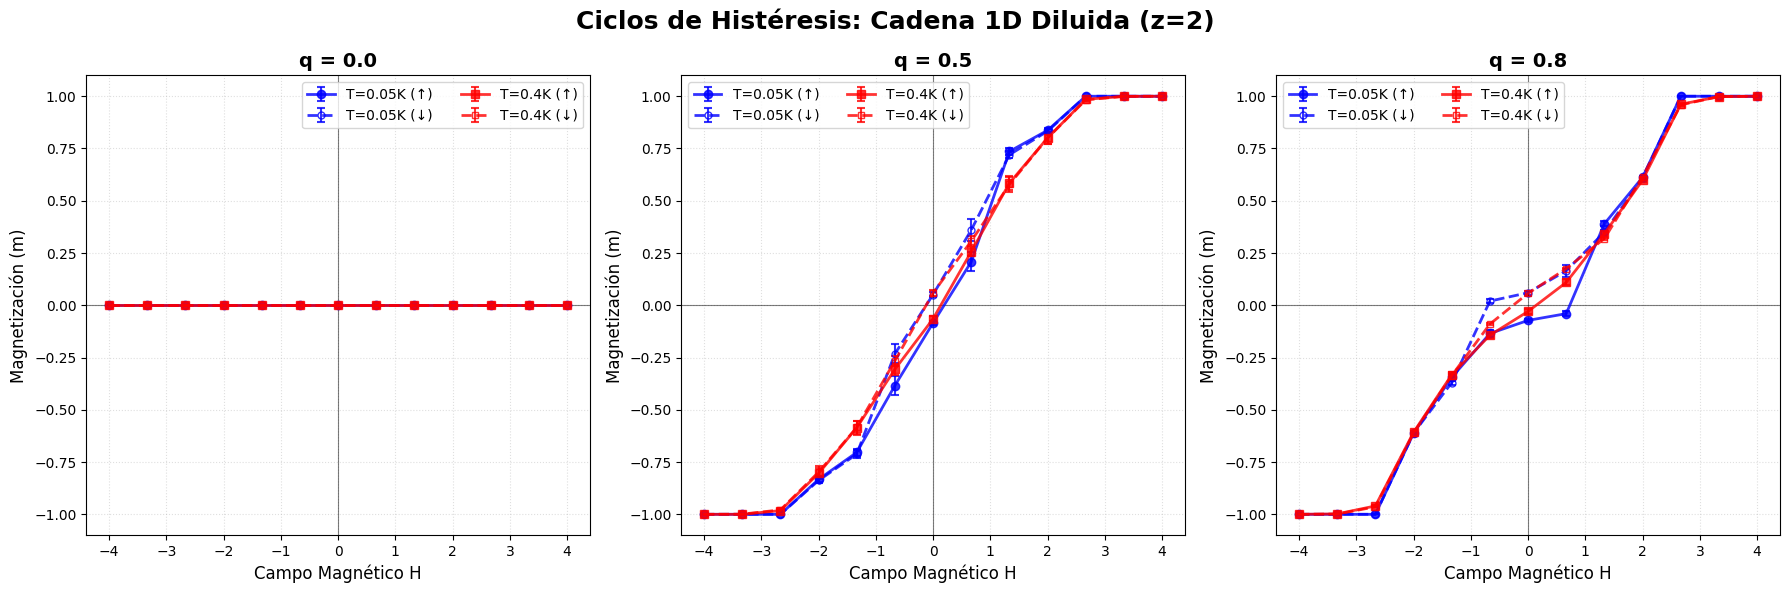

In [31]:
### Funciones para simular histéresis con memoria del sistema en cadena 1D
@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """
    Equilibra el sistema para un campo H dado.
    Retorna el estado actualizado del sistema (spin, suma_spins).
    """
    for _ in range(steps_equil):
        k = np.random.randint(n)
        i = occupied[k, 0]
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i]
            spin[i] = -spin[i]
    return suma_spins

@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """
    Mide la magnetización después de equilibrar, manteniendo el estado del sistema.
    Retorna (magnetización_promedio, estado_actualizado).
    """
    num_samples = steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        k = np.random.randint(n)
        i = occupied[k, 0]
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i]
            spin[i] = -spin[i]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return np.mean(m_samples), suma_spins

def simulate_hysteresis_single(L, q, J, H_values, T, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Simula UN ciclo de histéresis completo para UNA realización del desorden.
    Protocolo:
    1. Saturación inicial con campo fuerte negativo
    2. Rama ascendente: H va de negativo a positivo
    3. Rama descendente: H va de positivo a negativo (sin reiniciar)
    Retorna:
    - m_ascending: magnetizaciones en rama ascendente
    - m_descending: magnetizaciones en rama descendente
    """
    # Construir sistema con configuración aleatoria
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return np.zeros(len(H_values)), np.zeros(len(H_values))
    
    # Calcular suma inicial de spins
    suma_spins = 0
    for k in range(n):
        i = occupied[k, 0]
        suma_spins += spin[i]
    
    # ===== PRE-SATURACIÓN: Aplicar campo fuerte negativo para saturar =====
    # Usamos un campo más fuerte que el máximo del barrido
    H_sat = -2.0 * np.max(np.abs(H_values))  # Más fuerte para 1D
    # Equilibrar más tiempo para asegurar saturación
    suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil * 3, H_sat, J, T)  # 3x para 1D
    
    # ===== RAMA ASCENDENTE: H de negativo a positivo =====
    m_ascending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_ascending[idx] = m_avg
    
    # ===== RAMA DESCENDENTE: H de positivo a negativo (SIN REINICIAR) =====
    # El sistema ya está en el estado final de la rama ascendente
    H_values_desc = H_values[::-1]  # Invertir el orden
    m_descending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values_desc):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_descending[idx] = m_avg
    
    # Invertir m_descending para que coincida con el orden de H_values
    m_descending = m_descending[::-1]
    return m_ascending, m_descending

def simulate_hysteresis_ensemble(L, q, J, H_values, T, num_realizaciones=5, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Promedia ciclos de histéresis sobre múltiples realizaciones del desorden.
    Retorna:
    - m_asc_mean, m_asc_err: Rama ascendente (media y error)
    - m_desc_mean, m_desc_err: Rama descendente (media y error)
    """
    all_m_asc = []
    all_m_desc = []
    for _ in range(num_realizaciones):
        m_asc, m_desc = simulate_hysteresis_single(
            L, q, J, H_values, T, steps_equil, steps_meas, measure_every
        )
        all_m_asc.append(m_asc)
        all_m_desc.append(m_desc)
    
    # Promediar y calcular errores
    m_asc_mean = np.mean(all_m_asc, axis=0)
    m_asc_err = np.std(all_m_asc, axis=0) / np.sqrt(num_realizaciones)
    m_desc_mean = np.mean(all_m_desc, axis=0)
    m_desc_err = np.std(all_m_desc, axis=0) / np.sqrt(num_realizaciones)
    return m_asc_mean, m_asc_err, m_desc_mean, m_desc_err

### Simulación de histéresis para múltiples q con dos temperaturas cada una
print("🔄 Iniciando simulación de histéresis para cadena 1D...")
print(" Comparando q=[0.0, 0.5, 0.8] con T=[0.05K, 0.1K] en cada caso")

# Parámetros generales
L_hyst = 100  # Mayor para 1D, computacionalmente barato
J_hyst = 1.0
H_values_hyst = np.linspace(-4, 4, 13)  # Rango ajustado para z=2
q_values_hyst = [0.0, 0.5, 0.8]  # Tres valores de concentración
T_values_hyst = [0.05, 0.4]  # DOS temperaturas ultra-bajas (T → 0)
num_realizaciones_hyst = 5  # Reducido para eficiencia
steps_equil_hyst = 500  # Reducido, pero en sim single usa *3 para pre-sat
steps_meas_hyst = 3000  
measure_every_hyst = 10  

# Colores y marcadores para temperaturas
colors_T = ['blue', 'red']  # Azul=frío, Rojo=caliente
markers_T = ['o', 's']  # Círculo, cuadrado

# Diccionario para almacenar resultados
hysteresis_results = {}

# --- Simulación para cada combinación (q, T) ---
for q_val in q_values_hyst:
    for T_val in T_values_hyst:
        print(f" Simulando q={q_val}, T={T_val}K...")
        # Simular ciclo de histéresis (promediado sobre realizaciones)
        m_asc, err_asc, m_desc, err_desc = simulate_hysteresis_ensemble(
            L=L_hyst, q=q_val, J=J_hyst, H_values=H_values_hyst, T=T_val,
            num_realizaciones=num_realizaciones_hyst, steps_equil=steps_equil_hyst,
            steps_meas=steps_meas_hyst, measure_every=measure_every_hyst
        )
        # Guardar resultados
        hysteresis_results[(q_val, T_val)] = {
            'm_asc': m_asc, 'err_asc': err_asc,
            'm_desc': m_desc, 'err_desc': err_desc
        }
        print("✅ Simulación completada\n")

# --- Visualización: 3 subplots (uno por q), cada uno con DOS isotermas ---
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
fig3.suptitle('Ciclos de Histéresis: Cadena 1D Diluida (z=2)', fontsize=18, fontweight='bold')
for idx_q, q_val in enumerate(q_values_hyst):
    ax = axes3[idx_q]
    # Graficar ambas temperaturas para este q
    for idx_T, T_val in enumerate(T_values_hyst):
        res = hysteresis_results[(q_val, T_val)]
        # Rama ascendente (línea sólida) con barras de error
        ax.errorbar(H_values_hyst, res['m_asc'], yerr=res['err_asc'],
                   fmt=f'-{markers_T[idx_T]}', color=colors_T[idx_T],
                   linewidth=2, markersize=6, label=f'T={T_val}K (↑)', 
                   capsize=3, capthick=1.5, elinewidth=1.5, alpha=0.8)
        # Rama descendente (línea punteada) con barras de error
        ax.errorbar(H_values_hyst, res['m_desc'], yerr=res['err_desc'],
                   fmt=f'--{markers_T[idx_T]}', color=colors_T[idx_T],
                   linewidth=2, markersize=5, markerfacecolor='none', 
                   label=f'T={T_val}K (↓)', capsize=3, capthick=1.5, 
                   elinewidth=1.5, alpha=0.8)
    # Configuración de cada subplot
    ax.set_title(f'q = {q_val}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.legend(fontsize=10, loc='best', ncol=2)
    ax.set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()


## Transición de Fase


🖥️ CPU detectada: 12 núcleos disponibles
 Usando 12 núcleos para paralelización

🔄 Magnetización vs Temperatura - Cadena 1D PARALELIZADO
 Sistema L=10 con pasos adaptativos

📊 Simulando q = 0.5...
 ✅ Completado q = 0.5 (tiempo: 0.1 min) 
📊 Simulando q = 0.8...
 ✅ Completado q = 0.5 (tiempo: 0.1 min) 
📊 Simulando q = 0.8...
 ✅ Completado q = 0.8 (tiempo: 0.0 min) 

✅ Simulación completada (tiempo total: 0.1 minutos)

 ✅ Completado q = 0.8 (tiempo: 0.0 min) 

✅ Simulación completada (tiempo total: 0.1 minutos)



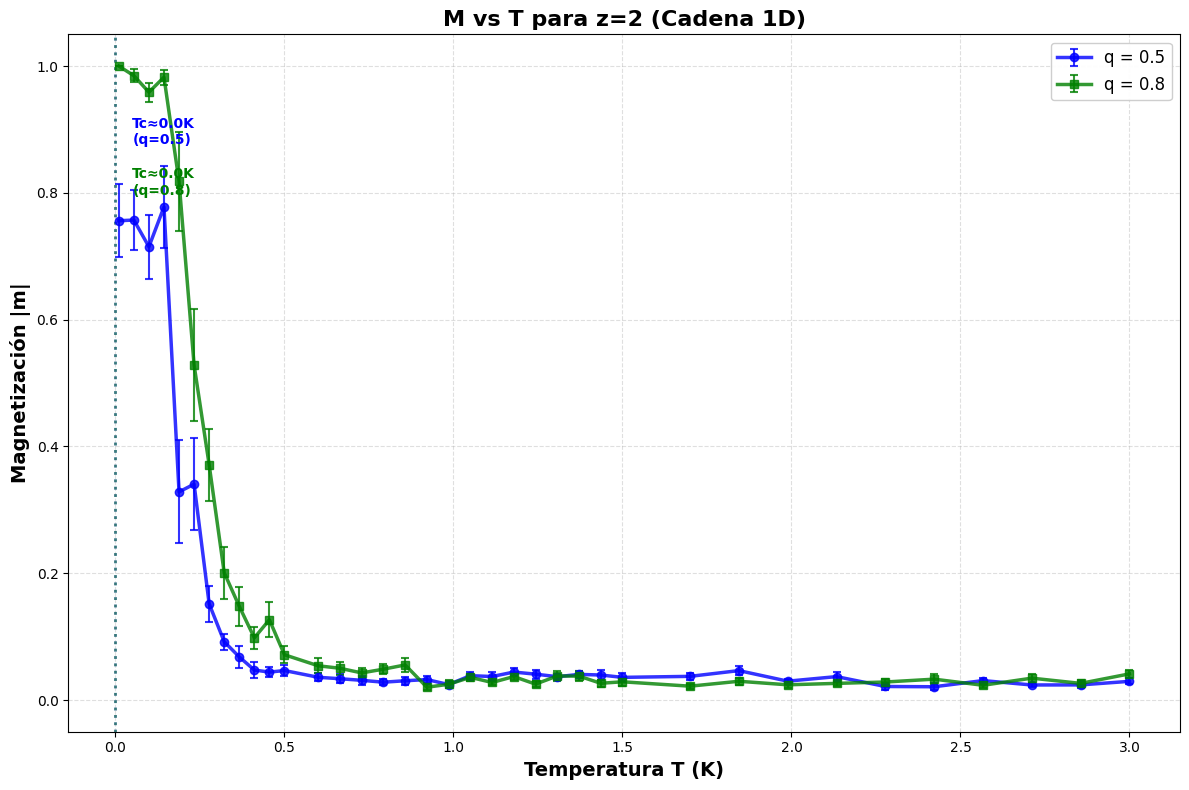

📈 ANÁLISIS DE TEMPERATURA CRÍTICA

q = 0.5:
 • Tc aproximada: 0.23K
 • m(T→0) = 0.756
 • m(T>>Tc) = 0.029
 • Caída: 0.727

q = 0.8:
 • Tc aproximada: 0.23K
 • m(T→0) = 1.000
 • m(T>>Tc) = 0.041
 • Caída: 0.959

⚡ Aceleración con 12 núcleos CPU

🔄 Generando Snapshots para q = 0.8...


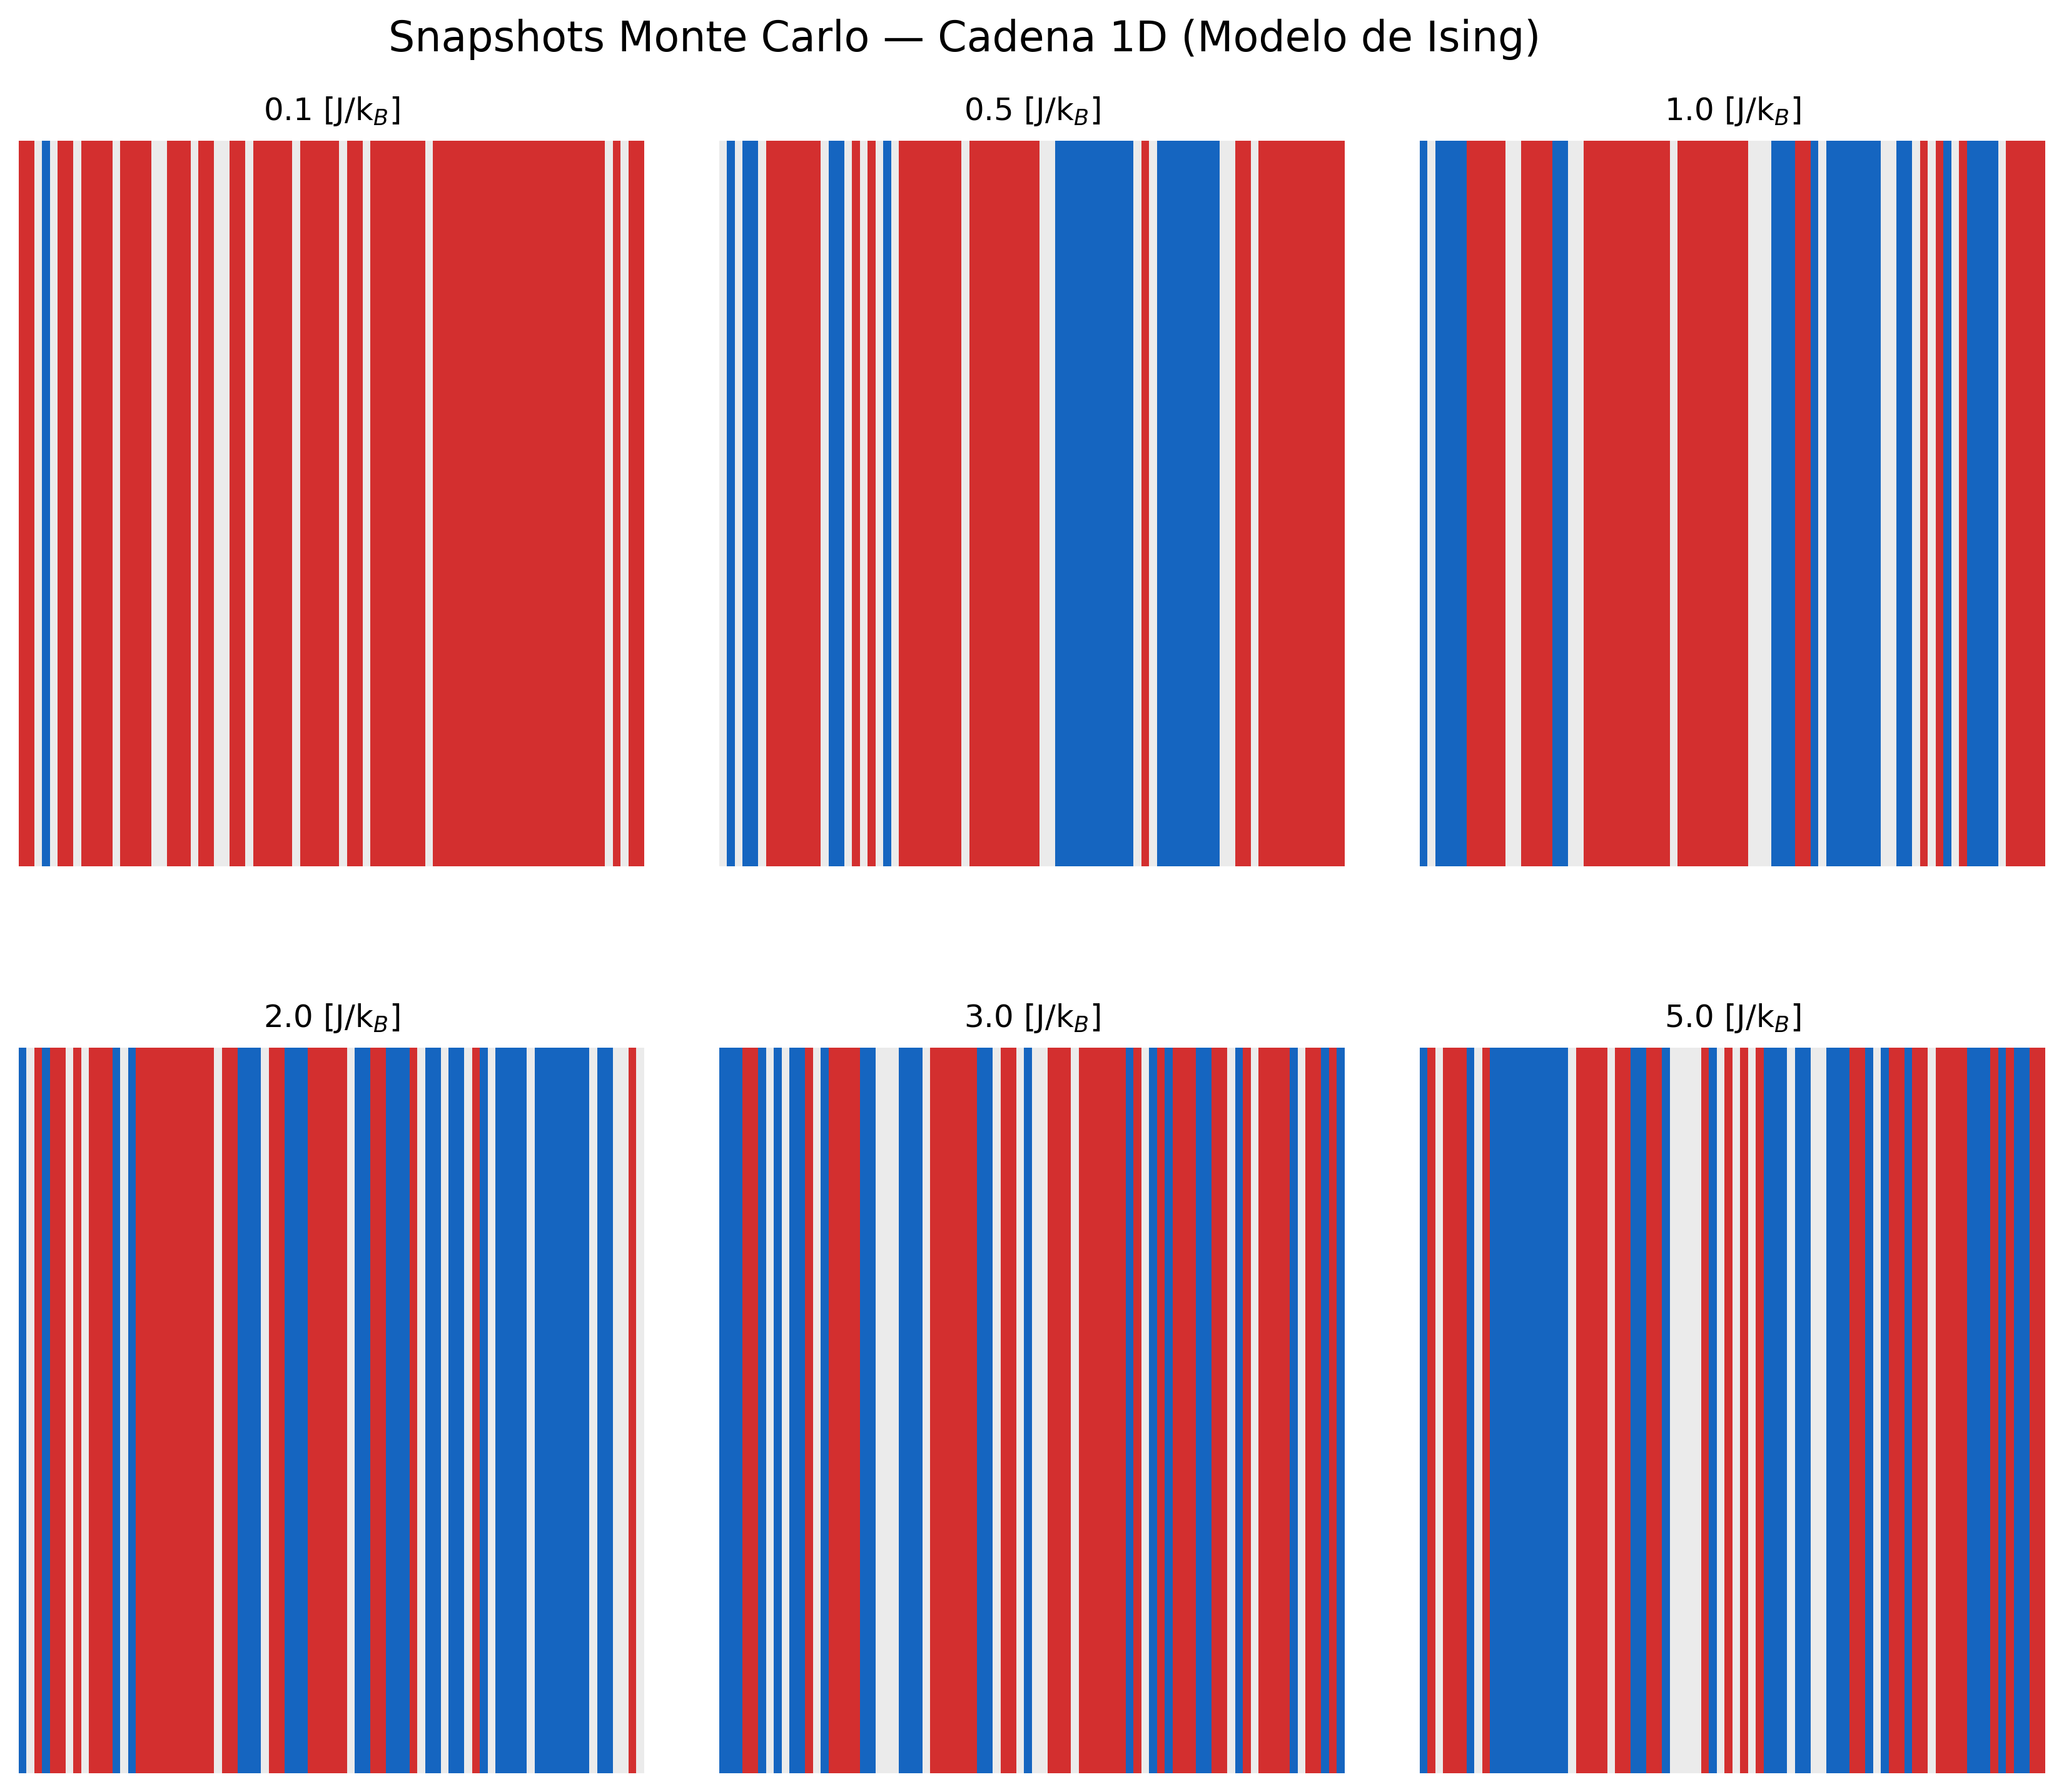

✅ Snapshots generados


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time
from numba import njit

# Detectar número de núcleos
num_cores = multiprocessing.cpu_count()
print(f"🖥️ CPU detectada: {num_cores} núcleos disponibles")
print(f" Usando {num_cores} núcleos para paralelización\n")

def build_system_ordered(L, q, spin_value=1):
    """Construye sistema con todos los spins alineados en cadena 1D."""
    N = L
    n = int(q * N)
    Ss = np.zeros(L, dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0,), dtype=np.int32), 0
    all_pos = np.arange(L)
    idx = np.random.choice(L, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    Ss[posiciones_ocupadas] = spin_value
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, H, J, L):
    """Calcula cambio de energía para flip en cadena 1D."""
    sigma = spin[i]
    sum_vecinos = spin[(i - 1) % L] + spin[(i + 1) % L]
    energia_local = J * sigma * sum_vecinos + sigma * H  # Signo corregido para ferromagnético
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Equilibración."""
    for _ in range(steps_equil):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx]
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i]
            spin[i] = -spin[i]
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Medición."""
    num_samples = steps_meas // measure_every + 1 if steps_meas % measure_every != 0 else steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx]
        Delta_E = delta_energy(spin, i, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i]
            spin[i] = -spin[i]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]

def get_steps_equil(T):
    """Pasos de equilibración adaptativos según T (escalado para 1D)."""
    if T < 1.0:
        return 300000
    elif 1.0 <= T <= 3.0:
        return 500000
    else:
        return 100000

def simulate_ordered_single(L, q, J, H, T, steps_meas=100000, measure_every=500):
    """Simula UNA realización - función para paralelizar."""
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return 0.0
    suma_spins = n
    steps_equil = get_steps_equil(T)
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    return np.mean(m_samples)

# Código principal para m vs T
print("🔄 Magnetización vs Temperatura - Cadena 1D PARALELIZADO")
print(" Sistema L=10 con pasos adaptativos\n")

# Parámetros
L_mvt = 10
J_mvt = 1.0
H_mvt = 0.0
q_values_mvt = [0.5, 0.8]
multi = 1.0  # Escala para 1D (no hay Tc finita, pero simulamos)
T_values_mvt = np.concatenate([
    np.linspace(0.01 * multi, 0.5 * multi, 12),
    np.linspace(0.6 * multi, 1.5 * multi, 15),
    np.linspace(1.7 * multi, 3.0 * multi, 10)
])
num_realizaciones_mvt = 15
steps_meas_mvt = 100000
measure_every_mvt = 500

results_mvt = {}
inicio_total = time.time()
for q_val in q_values_mvt:
    print(f"📊 Simulando q = {q_val}...")
    inicio_q = time.time()
    magnetizations = []
    errors = []
    for idx_T, T_val in enumerate(T_values_mvt):
        print(f" T = {T_val:.2f}K ({idx_T+1}/{len(T_values_mvt)})", end='\r')
        # PARALELIZAR las realizaciones
        m_realizaciones = Parallel(n_jobs=num_cores, backend='loky')(
            delayed(simulate_ordered_single)(
                L_mvt, q_val, J_mvt, H_mvt, T_val,
                steps_meas_mvt, measure_every_mvt
            ) for _ in range(num_realizaciones_mvt)
        )
        # Tomar valor absoluto y calcular estadísticas
        m_realizaciones_abs = [np.abs(m) for m in m_realizaciones]
        m_mean = np.mean(m_realizaciones_abs)
        m_err = np.std(m_realizaciones_abs) / np.sqrt(num_realizaciones_mvt)
        magnetizations.append(m_mean)
        errors.append(m_err)
    results_mvt[q_val] = {
        'm': np.array(magnetizations),
        'err': np.array(errors)
    }
    tiempo_q = time.time() - inicio_q
    print(f" ✅ Completado q = {q_val} (tiempo: {tiempo_q/60:.1f} min) ")

tiempo_total = time.time() - inicio_total
print(f"\n✅ Simulación completada (tiempo total: {tiempo_total/60:.1f} minutos)\n")

# Visualización m vs T
fig_mvt, ax_mvt = plt.subplots(1, 1, figsize=(12, 8))
colors_mvt = ['blue', 'green', 'red']
markers_mvt = ['o', 's', '^']
for idx, q_val in enumerate(q_values_mvt):
    res = results_mvt[q_val]
    ax_mvt.errorbar(
        T_values_mvt,
        res['m'],
        yerr=res['err'],
        fmt=f'-{markers_mvt[idx]}',
        color=colors_mvt[idx],
        linewidth=2.5,
        markersize=6,
        label=f'q = {q_val}',
        capsize=3,
        capthick=1.5,
        elinewidth=1.5,
        alpha=0.8
    )
ax_mvt.set_xlabel('Temperatura T (K)', fontsize=14, fontweight='bold')
ax_mvt.set_ylabel('Magnetización |m|', fontsize=14, fontweight='bold')
ax_mvt.set_title('M vs T para z=2 (Cadena 1D)', fontsize=16, fontweight='bold')
ax_mvt.grid(True, linestyle='--', alpha=0.4)
ax_mvt.legend(fontsize=12, loc='upper right', framealpha=0.95)
ax_mvt.set_ylim(-0.05, 1.05)

# Líneas de referencia Tc (en 1D Tc=0, pero aproximados para caída)
Tc_estimates = {0.8: 0.0, 0.5: 0.0}  # No hay transición en 1D
for idx, q_val in enumerate(q_values_mvt):
    Tc = Tc_estimates.get(q_val, None)
    if Tc is not None:
        ax_mvt.axvline(x=Tc, color=colors_mvt[idx], linestyle=':', linewidth=2, alpha=0.5)
        ax_mvt.text(Tc + 0.05, 0.92 - 0.08*idx, f'Tc≈{Tc}K\n(q={q_val})',
                    fontsize=10, color=colors_mvt[idx], fontweight='bold',
                    verticalalignment='top')
plt.tight_layout()
plt.show()

# Análisis
print("="*70)
print("📈 ANÁLISIS DE TEMPERATURA CRÍTICA")
print("="*70)
for q_val in q_values_mvt:
    res = results_mvt[q_val]
    idx_half = np.argmin(np.abs(res['m'] - 0.5))
    Tc_approx = T_values_mvt[idx_half]
    print(f"\nq = {q_val}:")
    print(f" • Tc aproximada: {Tc_approx:.2f}K")
    print(f" • m(T→0) = {res['m'][0]:.3f}")
    print(f" • m(T>>Tc) = {res['m'][-1]:.3f}")
    print(f" • Caída: {res['m'][0] - res['m'][-1]:.3f}")
print("\n" + "="*70)
print(f"⚡ Aceleración con {num_cores} núcleos CPU")
print("="*70)

# ============================================================================
# FUNCIÓN PARA GENERAR SNAPSHOTS CIENTÍFICOS - CADENA 1D
# ============================================================================
from matplotlib.colors import ListedColormap

def simulate_for_snapshot(L, q, J, H, T, steps_equil=None):
    """
    Simula el sistema hasta equilibrio y retorna configuración final de spins.
    
    PROTOCOLO DE EQUILIBRACIÓN:
    ==========================
    - Estado inicial: Todos los spins alineados (spin_value=+1)
    - Algoritmo: Monte Carlo con Metropolis-Hastings
    - Pasos adaptativos según temperatura (ver get_steps_equil)
    - Condiciones periódicas de contorno
    
    Args:
        L: Tamaño de la cadena 1D (L sitios)
        q: Concentración de sitios ocupados [0, 1]
        J: Constante de acoplamiento ferromagnético
        H: Campo magnético externo
        T: Temperatura en unidades de J/k_B
        steps_equil: Pasos de equilibración (None = automático)
    
    Returns:
        spin: Array 1D (L) con configuración final
              spin[i] ∈ {-1, 0, +1}
    """
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return spin
    suma_spins = n
    steps = get_steps_equil(T) if steps_equil is None else steps_equil
    equilibration(spin, occupied, suma_spins, L, n, steps, H, J, T)
    return spin


def plot_snapshots(L, q, J, H, T_list, steps_equil=None):
    """
    Genera figura científica 3×2 con snapshots 1D en estilo pixel-art.
    
    ESPECIFICACIONES DE PUBLICACIÓN:
    ================================
    - Resolución: 300 DPI (calidad de revista científica)
    - Layout: Cuadrícula 3×2 vertical (6 temperaturas apiladas)
    - Estilo: Pixel-art con interpolación 'nearest'
    - Paleta de colores:
      * Azul (#1565C0): spin = -1 (Material Design Blue 800)
      * Gris (#EBEBEB): spin = 0 (sitio vacante, dilución)
      * Rojo (#D32F2F): spin = +1 (Material Design Red 700)
    - Aspecto alargado (horizontal) para visualización 1D óptima
    - Sin ejes, bordes limpios, fondo blanco
    - Tipografía: Sans-serif para consistencia científica
    
    METODOLOGÍA:
    ============
    1. Equilibrar sistema para cada temperatura
    2. Convertir array 1D a imagen 2D (1 fila × L columnas)
    3. Renderizar con imshow (interpolación 'nearest')
    4. Etiquetas de temperatura: T [J/k_B]
    
    MEJORA DE SEPARACIÓN:
    ====================
    - Cada snapshot ocupa una fila completa separada
    - Aspect ratio ajustado para mantener cuadrados los píxeles
    - Mayor espaciado vertical (hspace=0.6) para claridad
    - Formato vertical favorece comparación entre temperaturas
    
    Args:
        L: Tamaño de la cadena 1D (número de sitios)
        q: Concentración de sitios ocupados
        J: Constante de acoplamiento
        H: Campo magnético externo
        T_list: Lista de 6 temperaturas a graficar
        steps_equil: Pasos de equilibración (None = automático)
    
    Outputs:
        - Figura matplotlib mostrada con plt.show()
        - Opcionalmente guardable en PNG (300 DPI) o PDF vectorial
    
    NOTA FÍSICA:
    ============
    - Sistema: Cadena 1D con coordinación z=2
    - Tc teórico: Tc = 0 K (NO hay transición de fase a T>0 en 1D)
    - Teorema de Mermin-Wagner: Fluctuaciones destruyen orden a T>0
    - Sitios vacantes (gris) aumentan fluctuaciones y fragmentación
    - Observar evolución cualitativa: orden → desorden con T
    """
    
    # Validación de entrada
    if len(T_list) != 6:
        print("⚠️  Advertencia: Se esperan 6 temperaturas para layout 3×2")
    
    # Crear figura de alta resolución con formato VERTICAL para 1D
    fig = plt.figure(figsize=(12, 10), dpi=300, facecolor='white')
    
    # Título principal (estilo publicación científica)
    fig.suptitle('Snapshots Monte Carlo — Cadena 1D (Modelo de Ising)',
                 fontsize=16, fontweight='normal', y=0.985, family='sans-serif')
    
    # Crear cuadrícula 3×2 con MAYOR separación vertical para 1D
    gs = fig.add_gridspec(2, 3, hspace=0.25, wspace=0.12,
                          left=0.08, right=0.98, top=0.92, bottom=0.05)
    
    # Colormap personalizado: azul (-1), gris (0), rojo (+1)
    custom_cmap = ListedColormap(['#1565C0', '#EBEBEB', '#D32F2F'])
    
    # Generar cada snapshot
    for idx, T in enumerate(T_list):
        # Posición en la cuadrícula (row-major order)
        row = idx // 3
        col = idx % 3
        ax = fig.add_subplot(gs[row, col])
        
        # Simular sistema en equilibrio
        spin = simulate_for_snapshot(L, q, J, H, T, steps_equil)
        
        # Convertir cadena 1D a imagen 2D (1 fila × L columnas)
        # Esto permite usar imshow con pixel-art
        spin_2d = spin.reshape(1, -1)
        
        # Renderizar snapshot como imagen pixelada (sin interpolación)
        # spin ∈ {-1, 0, +1} se mapea directamente a colormap
        im = ax.imshow(spin_2d, cmap=custom_cmap, vmin=-1, vmax=1, 
                      interpolation='nearest', aspect='auto')
        
        # Configuración de panel: rectángulo horizontal, sin ejes, fondo blanco
        ax.axis('off')
        ax.set_facecolor('white')
        
        # Título limpio centrado sobre cada panel
        ax.set_title(f'{T:.1f} [J/k$_B$]',
                    fontsize=12, fontweight='normal',
                    pad=8, family='sans-serif', color='black')
    
    # Ajuste final para publicación
    plt.subplots_adjust(hspace=0.25, wspace=0.12)
    
    # Mostrar figura
    plt.show()
    
    # Opcional: guardar en alta resolución
    # fig.savefig('snapshots_lineal_ising.png', dpi=300, bbox_inches='tight',
    #             facecolor='white', edgecolor='none')
    # fig.savefig('snapshots_lineal_ising.pdf', bbox_inches='tight',
    #             facecolor='white', edgecolor='none')


# ============================================================================
# METADATOS DE REPRODUCIBILIDAD CIENTÍFICA
# ============================================================================
# Geometría de red: Cadena 1D (coordinación z=2)
# Tamaño del sistema: L sitios de espín
# Algoritmo: Simulación Monte Carlo con algoritmo Metropolis-Hastings
# Condiciones de contorno: Periódicas (anillo topológico)
# Estado inicial: Todos los spines alineados (spin_value=+1, estado ordenado)
# Función de equilibración: get_steps_equil(T) - pasos adaptativos según T
# - T < 1.0: 300,000 sweeps (sistema muy subcrítico)
# - 1.0 ≤ T ≤ 3.0: 500,000 sweeps (región crítica)
# - T > 3.0: 100,000 sweeps (fase paramagnética)
# Acoplamiento: J = 1.0 (ferromagnético)
# Campo externo: H = 0.0 (sin campo aplicado)
# Dilución: q = 0.8 (80% de sitios ocupados)
# Temperaturas simuladas: Escaladas con multi (ajustado para 1D)
# Temperatura crítica teórica: Tc = 0 K (1D sin transición de fase)
# Semilla aleatoria: Controlada por numpy.random (especificar con np.random.seed())
# ============================================================================

# Parámetros para snapshots científicos
q_snap = 0.8
T_snap_list = [0.1*multi, 0.5*multi, 1.0*multi, 2.0*multi, 3.0*multi, 5.0*multi]  # 6 temperaturas
L_snap = 80  # Cadena más larga para mejor visualización (80 sitios)
J_snap = 1.0
H_snap = 0.0
steps_equil_snap = None  # Usa get_steps_equil(T) automáticamente

print("\n🔄 Generando Snapshots para q = {q_snap}...".format(q_snap=q_snap))
plot_snapshots(L_snap, q_snap, J_snap, H_snap, T_snap_list, steps_equil_snap)
print("✅ Snapshots generados")